In [1]:
import numpy as np
import time

class Conv3x3:
    
    def __init__(self, num_filters,f,n_c):
        self.num_filters = num_filters
        self.n_c = n_c
        self.f = f
        self.filters = np.random.normal(loc=0, scale=np.sqrt(1./(self.n_c*self.f*self.f)), size=(num_filters,self.n_c, self.f, self.f))
        self.t_f = 0
        
    def forward(self, input):
        
        u = time.time()
        
        self.last_input = input
    
        h, w , n_c = input.shape
        
        
        output = np.zeros((h - self.f+1, w - self.f+1, self.num_filters),dtype=np.float64)
    
        for i in range(h-self.f+1):
            for j in range(w-self.f+1):
                for k in range(self.num_filters):
                    for n in range(self.n_c):
                        
                        temp = np.logical_and(input[i:i+self.f,j:j+self.f,n],self.filters[k,n,:,:])
                        
                        output[i, j , k] += np.sum(input[i:i+self.f,j:j+self.f,n][temp==True] * self.filters[k,n,:,:][temp==True])
                            
                output[i,j,k] = np.maximum(0,output[i,j,k])
                    
        self.last_output = output

        v =  time.time()
        
        self.t_f += v-u
        
        return output
    
    def backprop(self, d_L_d_out, learn_rate):
        
        d_L_d_out[self.last_output<0] = 0
        
        d_L_d_filters = np.zeros(self.filters.shape,dtype=np.float64)
    
        h,w,c = self.last_input.shape
        d_L_d_i = np.zeros((h,w,c))
        for i in range(h-self.f+1):
            for j in range(w-self.f+1):
                  for f in range(self.num_filters):
                        for n in range(self.n_c):
                            d_L_d_filters[f,n,:,:] += d_L_d_out[i, j, f] * self.last_input[i:i+self.f,j:j+self.f,n]
                            d_L_d_i[i:i+self.f,j:j+self.f,n] += d_L_d_out[i, j, f] * self.filters[f,n,:,:]
                            
        self.filters -= learn_rate * d_L_d_filters

        return d_L_d_i
    

In [2]:
import numpy as np


class MaxPool2:
    
    def iterate_regions(self, image):
        h, w, _ = image.shape
        new_h = h // 2
        new_w = w // 2
    
        for i in range(new_h):
            for j in range(new_w):
                im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
                yield im_region, i, j
    
    def forward(self, input):
    
        self.last_input = input

        h, w, num_filters = input.shape
        output = np.zeros((h // 2, w // 2, num_filters))

        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.amax(im_region, axis=(0, 1))

        return output

    def backprop(self, d_L_d_out):
       
        d_L_d_input = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            h, w, f = im_region.shape
            amax = np.amax(im_region, axis=(0, 1))

            for i2 in range(h):
                for j2 in range(w):
                      for f2 in range(f):
                        # If this pixel was the max value, copy the gradient to it.
                            if im_region[i2, j2, f2] == amax[f2]:
                                  d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

        return d_L_d_input

In [3]:
import numpy as np

class Softmax:

    def __init__(self, input_len, nodes):
        self.weights = np.random.normal(loc=0, scale=np.sqrt(1./(input_len*nodes)), size=(input_len,nodes))

        self.biases = np.random.normal(loc=0, scale=np.sqrt(1./(nodes)), size=(nodes))

    def forward(self, input):
        
        
        self.last_input_shape = input.shape

        input = input.flatten()
        
        self.last_input = input

        input_len, nodes = self.weights.shape[0],self.weights.shape[1]

        totals = np.dot(input, self.weights) + self.biases
        
        totals -= np.max(totals)
        
        self.last_totals = totals

        exp = np.exp(totals,dtype=np.float64)
        
        return exp / np.sum(exp, axis=0)

    def backprop(self, d_L_d_out, learn_rate):
        
        for i, gradient in enumerate(d_L_d_out):
            if gradient == 0:
                continue

            t_exp = np.exp(self.last_totals)

            S = np.sum(t_exp)

            d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
            d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)
            
            d_t_d_w = self.last_input
            d_t_d_b = 1
            d_t_d_inputs = self.weights

            d_L_d_t = gradient * d_out_d_t

            d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
            d_L_d_b = d_L_d_t * d_t_d_b
            d_L_d_inputs = d_t_d_inputs @ d_L_d_t

            self.weights -= learn_rate * d_L_d_w
            self.biases -= learn_rate * d_L_d_b

            return d_L_d_inputs.reshape(self.last_input_shape) 

In [4]:
import numpy as np
import keras
from keras.datasets import mnist



train_images = np.zeros([400,28,28,1])
test_images = np.zeros([100,28,28,1])

(images_tr, train_labels), (images_ts1, test_labels) = mnist.load_data()

images_tr = np.array(images_tr[:400])
train_labels = np.array(train_labels[:400])
    
images_ts = np.array(images_ts1[:100])
test_labels = np.array(test_labels[0:100])


for i in range(400):
    train_images[i] = images_tr[i].reshape(28,28,1) 
    
for i in range(100):    
    test_images[i] = images_ts[i].reshape(28,28,1)
    
#print(train_images[0])

C:\Users\hp\Anaconda31\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
import mnist
import numpy as np
import tqdm as tqdm

conv1 = Conv3x3(8,3,1)
pool1 = MaxPool2()                  

conv2 = Conv3x3(8,3,1)
pool2 = MaxPool2()                  

softmax = Softmax(200, 10) 

def forward(image, label): 
    
    out = conv1.forward((image/255) )
    out = pool1.forward(out)
    
    out = conv2.forward(out)
    out = pool2.forward(out)
    
    out = softmax.forward(out)
    
    if out[label] == 0:
        out[label] = sys.float_info.min
    
    
    loss = -np.log(out[label])
    acc = 1 if np.argmax(out) == label else 0

    return out, loss, acc

def train(im, label, lr=.005):
   
    out, loss, acc = forward(im, label)

    gradient = np.zeros(10)
    if out[label] == 0:
        out[label] = sys.float_info.min
    gradient[label] = -1 / out[label]

    gradient = softmax.backprop(gradient, lr)
    gradient = pool2.backprop(gradient)
    gradient = conv2.backprop(gradient, lr)
    gradient = pool1.backprop(gradient)
    gradient = conv1.backprop(gradient, lr)
    
    return loss, acc

t1 = time.time()
for epoch in range(3):
#     break
    print('\n')
    print('--- Epoch %d ---' % (epoch + 1))

    permutation = np.random.permutation(len(train_images))
    train_images = train_images[permutation]
    train_labels = train_labels[permutation]
    
    loss = 0
    num_correct = 0
    outer = tqdm.tqdm(total=len(train_images), desc='training_data', position=0)
    
    for i, (im, label) in enumerate(zip(train_images, train_labels)):
        outer.update(1)
        l, acc = train(im, label)
        loss += l
        num_correct += acc
        
        
        
    print('after epoch' + str(epoch+1) + ' loss is ' + str(loss/len(train_images)) + ' accuracy is ' + str(num_correct/len(train_images)))
    
    
t2 = time.time()

total_time = t2-t1

total_time_conv = conv1.t_f + conv2.t_f 
        
        
print('Testing on test data set')
loss = 0
num_correct = 0

test = tqdm.tqdm(total=len(test_images), desc='test_data', position=0)
    
for im, label in zip(test_images, test_labels):
    test.update(1)
    _, l, acc = forward(im, label)
    loss += l
    num_correct += acc



num_tests = len(test_images)
print('Loss on test dataset:', loss / num_tests)
print('Accuracy on test dataset:', num_correct / num_tests)
print('\n')
print('total time taken is ',total_time)
print('total time taken for conv forward prop is ',total_time_conv)

training_data:   0%|▎                                                                  | 2/400 [00:00<00:30, 13.25it/s]



--- Epoch 1 ---


training_data:   0%|▎                                                                  | 2/400 [00:00<00:35, 11.23it/s]

after epoch1 loss is 2.1371514753066414 accuracy is 0.3225


--- Epoch 2 ---


training_data:   0%|                                                                           | 0/400 [00:00<?, ?it/s]

after epoch2 loss is 1.5683861670699781 accuracy is 0.6125


--- Epoch 3 ---


test_data:   2%|█▍                                                                     | 2/100 [00:00<00:05, 17.14it/s]

after epoch3 loss is 0.7721954664608355 accuracy is 0.785
Testing on test data set


test_data: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.34it/s]

Loss on test dataset: 0.5923286608955951
Accuracy on test dataset: 0.82


total time taken is  293.6001307964325
total time taken for conv forward prop is  134.80283522605896


# Ignore the below blocks

test cases: 

 


input image :


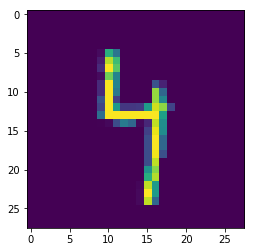

 predicted Output

TypeError: forward() missing 1 required positional argument: 'input'

In [10]:
from random import randint
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, show

def predict_out(image):
    
    out = conv1.forward((image / 255) - 0.5)
    out = pool1.forward(out)
    out = Softmax.forward(out)
    
    return np.argmax(out)



print("test cases: \n\n ")

for j in range(7):
    rand = randint(1000,2000)
    print("\n\ninput image :")
    test_img = np.array(images_ts1[rand]).reshape(28,28)
    imshow(test_img)
    show()
    
    print(" predicted Output" , end = "")
    print(predict_out(test_img.reshape(28,28,1)))
    
    
    